In [1]:
import numpy as np
from qutip import sigmax, sigmay, sigmaz, qeye, tensor
import matplotlib.pyplot as plt
import pennylane as qml
from skopt import gp_minimize
from skopt.space import Real
import sobol_seq  
from concurrent.futures import ThreadPoolExecutor
from scipy.optimize import minimize
import logging
import pickle
from scipy.sparse.linalg import eigsh
import scipy.sparse as sp
from joblib import Parallel, delayed
import numba

In [2]:
def heisenberg_hamiltonian(N, J1, indx1):
    """Constructs the sparse Heisenberg Hamiltonian for N spins."""
    
    H = None  # Initialize Hamiltonian
    
    Sx, Sy, Sz = sigmax(), sigmay(), sigmaz()
    I = qeye(2)  # Identity matrix for a single spin

    for i in range(N):
        for j in range(i + 1, N):  # Avoid double counting
            
            if indx1[i, j]:  # Nearest-neighbor interaction
                term = J1[0] * tensor(*[Sx if k in (i, j) else I for k in range(N)]) + \
                       J1[1] * tensor(*[Sy if k in (i, j) else I for k in range(N)]) + \
                       J1[2] * tensor(*[Sz if k in (i, j) else I for k in range(N)])
                H = term if H is None else H + term

    return H

def zeeman_hamiltonian(N, B):
    """Constructs the sparse Zeeman Hamiltonian for N spins."""
    
    Hz = None  

    Sx, Sy, Sz = sigmax(), sigmay(), sigmaz()
    I = qeye(2)  

    for i in range(N):
        term = B[0] * tensor(*[Sx if k == i else I for k in range(N)]) + \
               B[1] * tensor(*[Sy if k == i else I for k in range(N)]) + \
               B[2] * tensor(*[Sz if k == i else I for k in range(N)])
        Hz = term if Hz is None else Hz + term

    return Hz

def find_ground_state(N, J1, indx1, B):
    """Computes the ground state and energy using sparse methods."""
    
    H = heisenberg_hamiltonian(N, J1, indx1) + zeeman_hamiltonian(N, B)
    
    # Convert to SciPy sparse matrix
    H_sparse = H.data.as_scipy()  # Convert to SciPy sparse format

    # Compute only the lowest eigenvalue and eigenvector using a sparse solver
    eigenvalues, eigenvectors = eigsh(H_sparse, k=1, which="SA")  # Smallest eigenvalue

    ground_energy = eigenvalues[0]
    ground_state = eigenvectors[:, 0]  # First column is the ground state

    return ground_state, ground_energy


In [3]:
def generate_indices(N):
    # Initialize indx1 and indx2 as NxN zero matrices
    indx1 = np.zeros((N, N), dtype=int)

    # Fill indx1 based on the observed pattern (nearest neighbors with PBC)
    for i in range(N):
        indx1[i, (i - 1) % N] = 1  # Left neighbor (with PBC)
        indx1[i, (i + 1) % N] = 1  # Right neighbor (with PBC)

    return indx1

In [4]:
# Sobol sequence sampler for better parameter initialization
def sobol_sampler(dim, num_samples):
    samples = sobol_seq.i4_sobol_generate(dim, num_samples)  # Generate Sobol sequence
    return samples * 2 * np.pi  # Scale to [0, 2π] range

# Step 1: Monte Carlo Search (Global Exploration)
def monte_carlo_search(psi, num_params, num_samples, overlap_func):
    sobol_samples = sobol_sampler(num_params, num_samples)  # Generate Sobol sequence

    def evaluate_sample(params):
        return overlap_func(psi, *params)  # Explicitly use the passed overlap function

    # Run sequentially for debugging (use ProcessPoolExecutor for parallelism)
    overlaps = [evaluate_sample(params) for params in sobol_samples]

    best_idx = np.argmin(overlaps)  # Get index of best candidate
    return sobol_samples[best_idx]  # Return best parameter set


def refine_with_gradient(psi, initial_guess, overlap_func, method="BFGS"):
    result = minimize(
        lambda params: overlap_func(psi, *params),  # Explicitly pass overlap function
        initial_guess,
        method=method
    )
    return result.fun, result.x  # Return best GE and optimized parameters


def hybrid_optimization(psi, num_params, num_samples, overlap_func):
    best_mc_guess = monte_carlo_search(psi, num_params, num_samples, overlap_func)  # Pass function
    best_GE, best_params = refine_with_gradient(psi, best_mc_guess, overlap_func)  # Pass function
    return best_GE, best_params

In [5]:
# Define the quantum device

# Define the custom two-qubit operation
def custom_two_qubit_operation(wires, c1, c2, c3):
    control, target = wires  # Extract control and target qubit indices

    # Entangling operation sequence
    qml.CNOT(wires=[control, target])
    qml.RX(c1, wires=target)
    qml.CNOT(wires=[control, target])
    qml.CNOT(wires=[target, control])
    qml.RZ(c3, wires=target)
    qml.CNOT(wires=[target, control])
    qml.CY(wires=[control, target])
    qml.RY(c2, wires=target)
    qml.CY(wires=[control, target])

def create_device(N):
    return qml.device("default.qubit", wires=N)

# Define the bipartite circuit
def create_qnode(N):
    dev = create_device(N)
    
    @qml.qnode(dev)
    def rotate_x_z(phi1, beta1, phi2, beta2): # the ring is partitioned into pairs of qubits
        # Partition the qubits into even and odd sets
        even_indices = list(range(0, N, 2))  # {0,2,4,6,...}
        odd_indices = list(range(1, N, 2))   # {1,3,5,7,...}
        
        # Apply RX rotation to all qubits
        for i in  range(len(even_indices)):
            qml.RX(phi1, wires=even_indices[i])
        for i in  range(len(odd_indices)):
            qml.RX(phi2, wires=odd_indices[i])


        # Apply RZ rotation to all qubits
        for i in  range(len(even_indices)):
            qml.RZ(beta1, wires=even_indices[i])
        for i in  range(len(odd_indices)):
            qml.RZ(beta2, wires=odd_indices[i])

        return qml.state()  # Return state vector
    
    @qml.qnode(dev)
    def circuit_parts(phi1, beta1, phi2, beta2, c1, c2, c3, parts):
        
        even_indices = list(range(0, N, 2))  # {0,2,4,6,...}
        odd_indices = list(range(1, N, 2))   # {1,3,5,7,...}
        
        # Apply RX rotation to all qubits
        for i in  range(len(even_indices)):
            qml.RX(phi1, wires=even_indices[i])
        for i in  range(len(odd_indices)):
            qml.RX(phi2, wires=odd_indices[i])
        
        rows, cols = parts.shape

        for i in range(rows):
            for j in range(cols-1): 
                wires = [parts[i, j], parts[i, j+1]]
                custom_two_qubit_operation(wires, c1, c2, c3)   
        
        # Apply RZ rotation to all qubits
        for i in  range(len(even_indices)):
            qml.RZ(beta1, wires=even_indices[i])
        for i in  range(len(odd_indices)):
            qml.RZ(beta2, wires=odd_indices[i])
            
        return qml.state()  # Return the final state
    
    return rotate_x_z, circuit_parts

In [6]:
# Finding ground state
# Target ground state for N number of spins
def GS_p(p,d, N):
    J=0.25
    J1 = np.array([J, J,J*d])  # nearest-neighbor coupling constant
    B=np.array([0, 0,-p])
    indx1 = generate_indices(N)
    
    # Find ground state and energy
    ground_state, ground_energy = find_ground_state(N, J1, indx1,B)
    
    ground_state = ground_state.flatten()

    return ground_state

# Evaluate GE for a range of p values
p_values = np.linspace(-3, 3, 17)

# Ensure 1, 1.03, and 0.97 are included
required_values = {-1, 1, 1.25, 1.5}
p_values = np.unique(np.append(p_values, list(required_values)))  # Add and remove duplicates

# Sort the array
p_values.sort()

NS=16 # Number of spins
psis0 = [GS_p(p, 2,NS) for p in p_values]  # r=0 isotropic XY (or XX) model
psis1 = [GS_p(p, 1.5,NS) for p in p_values]  # r=1 ising model
psishalf = [GS_p(p, 1,NS) for p in p_values]  # r=1/2 XY  model


In [7]:
# Save to a file using pickle
with open('dataXXZ-1Dhne016.pkl', 'wb') as f:
    pickle.dump({'p_values': p_values, 'psis0': psis0, 'psis1': psis1, 'psishalf': psishalf}, f)

In [8]:
# Load the data from the file
with open('dataXXZ-1Dhne016.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert the lists to NumPy arrays
p_values=np.array(data['p_values'])
psis0 = np.array(data['psis0'])
psis1 = np.array(data['psis1'])
psishalf = np.array(data['psishalf'])

print(psis0.shape)

print(p_values)
print(psis0[0])
print(psis1[0])
print(psishalf[0])

(20, 65536)
[-3.    -2.625 -2.25  -1.875 -1.5   -1.125 -1.    -0.75  -0.375  0.
  0.375  0.75   1.     1.125  1.25   1.5    1.875  2.25   2.625  3.   ]
[-1.60549311e-16-3.82914999e-19j -6.12003158e-17-7.65133128e-17j
 -3.58943281e-17-3.45007875e-17j ...  4.71313369e-16-2.05209122e-16j
  1.37286245e-16-3.03956624e-17j -9.30011641e-01+3.67530064e-01j]
[ 4.49878632e-18-2.49240096e-17j  2.20915369e-18+4.63444504e-18j
  1.84151803e-18+8.55909642e-18j ... -6.07616108e-16-6.53726629e-16j
  1.20538017e-15+1.78814183e-15j -8.12599896e-01-5.82821936e-01j]
[ 1.17290174e-17-4.70464962e-17j -1.35590604e-18+1.57419879e-17j
  7.14785132e-19-1.89631751e-18j ... -1.18132656e-15-2.35626470e-17j
  5.50753918e-16-3.26604033e-16j  7.87045891e-01-6.16894452e-01j]


In [9]:
#Total entanglment
rotate_x_z, circuit_parts=create_qnode(NS)

# Overlap function: fidelity between target state (psi) and unentangled state
def overlap(psi, phi1, beta1, phi2, beta2):
    state = rotate_x_z(phi1, beta1, phi2, beta2)  # Get the rotated state
    overlap_value = np.abs(np.vdot(psi, state)) ** 2  # Calculate fidelity (overlap)
    return 1 - overlap_value  # Minimize (1 - fidelity)

num_samples = 2000  # Number of Sobol samples

optimal_values1 = []
optimal_values2 = []
optimal_values3 = []

# Perform hybrid optimization for each p
num_params=4
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis0[i], num_params, num_samples, overlap) 
    optimal_values1.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psishalf[i], num_params, num_samples, overlap) 
    optimal_values2.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis1[i], num_params, num_samples, overlap) 
    optimal_values3.append(best_overlap)

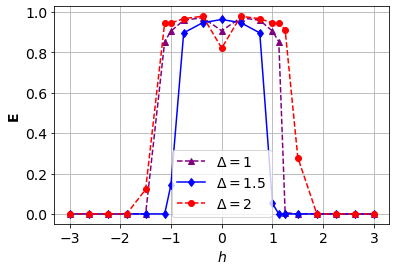

In [10]:
# Plot the results
plt.plot(p_values, optimal_values3, color='purple', linestyle='--', marker='^', label=r"$\Delta=1$")  
plt.plot(p_values, optimal_values2, 'b-d', label=r"$\Delta=1.5$")  
plt.plot(p_values, optimal_values1, 'r--o', label=r"$\Delta=2$")  
plt.xlabel(r"$h$", fontsize=14, fontweight='bold')
plt.ylabel("E", fontsize=14, fontweight='bold')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

plt.xlabel(r"$h$", fontsize=14, fontweight='bold')
plt.ylabel("E", fontsize=14, fontweight='bold')

# Place the legend outside the plot
plt.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# Adjust layout to avoid clipping of legend
plt.tight_layout()

plt.show()

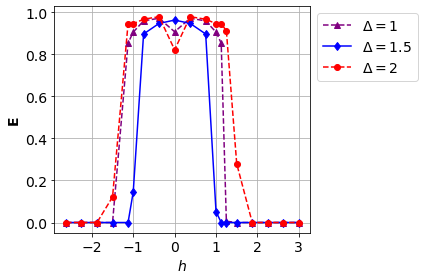

In [14]:
# Plot the results
plt.plot(p_values, optimal_values3, color='purple', linestyle='--', marker='^', label=r"$\Delta=1$")  
plt.plot(p_values, optimal_values2, 'b-d', label=r"$\Delta=1.5$")  
plt.plot(p_values, optimal_values1, 'r--o', label=r"$\Delta=2$") 

plt.xlabel(r"$h$", fontsize=14, fontweight='bold')
plt.ylabel("E", fontsize=14, fontweight='bold')

# Place the legend outside the plot
plt.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# Adjust layout to avoid clipping of legend
plt.tight_layout()

plt.show()
